In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
def save_plot(fig, pltname, artists=(), size_inches=(4,4)):
    fig.set_size_inches(size_inches)
    fig.savefig(os.path.join("..", "figures", "permutation_tests_" + pltname + ".png"), dpi=300, bbox_extra_artists=artists, bbox_inches='tight')

In [4]:
# Load up the mapping file
df_mapping = pd.read_csv("../data/SampleID_map.txt", sep='\t', index_col=0)
df_mapping.head()

,UserName,StudyDayNo,StudyDate,Gender,Age,Weight,Height,BMI,Supplement,Waist.Circumference,...,fecal.time,BMI.1,Weight.Change,Plate,SampleOrder,SampleType,Timing,Activity.Factor,Medications,Dietary.Supp
#SampleID,,,,,,,,,,,,,,,,,,,,,
Blank.A02.,Blank_A02,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.A03.,Blank_A03,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.A04.,Blank_A04,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.A07.,Blank_A07,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,Blank,NaN,NaN,NaN,NaN
Blank.B12.,Blank_B12,17,2/16/17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,Blank,NaN,NaN,NaN,NaN


In [5]:
# Load up the distance matrix
df_distance = pd.read_csv("../data/AllRf.dm.txt", sep='\t', index_col=0)
# Reflect lower triangle to upper triangle
for i in range(df_distance.shape[0]):
    for j in range(i, df_distance.shape[1]):
        df_distance.iloc[i, j] = df_distance.iloc[j, i]
df_distance.head()

,MCT.f.0072,MCT.f.0014,MCT.f.0269,MCT.f.0259,MCT.f.0221,MCT.f.0426,MCT.f.0590,MCT.f.0624,MCT.f.0138,MCT.f.0166,...,MCT.f.0404,MCT.f.0439,MCT.f.0365,MCT.f.0220,MCT.f.0048,MCT.f.0456,MCT.f.0550,MCT.f.0524,MCT.f.0489,MCT.f.0621
MCT.f.0072,1.0000,2.5560,2.5009,2.4233,2.4425,2.2992,3.0320,2.0747,2.3113,2.5819,...,3.0163,2.4577,2.5237,2.5709,2.3318,2.3771,2.3528,2.8761,3.2440,2.1268
MCT.f.0014,2.5560,1.0000,2.3440,2.5015,2.4130,2.4851,2.6786,2.7548,2.4207,2.3409,...,2.9536,2.4503,2.3645,2.5488,2.4964,2.3574,2.3724,2.8883,2.8061,2.7111
MCT.f.0269,2.5009,2.3440,1.0000,2.2691,2.4331,2.4931,2.8162,2.6454,2.4783,2.5384,...,3.0341,2.5369,2.4298,2.5900,2.5071,2.4186,2.4096,2.9128,2.8895,2.6058
MCT.f.0259,2.4233,2.5015,2.2691,1.0000,2.4704,2.4973,2.9089,2.5159,2.4960,2.6310,...,3.0832,2.5564,2.5028,2.6198,2.5343,2.4570,2.4483,2.9434,2.9876,2.5266
MCT.f.0221,2.4425,2.4130,2.4331,2.4704,1.0000,2.3441,2.7912,2.3562,2.4271,2.4306,...,3.0070,2.3995,2.4515,2.1220,2.4451,2.4111,2.2562,2.8241,2.9270,2.3435


In [6]:
# summary statistic
def difference_of_stats(samples, df_distance):
    s = 0.
    for i in range(len(samples)-1):
        s += df_distance[samples[i]][samples[i+1]]
    return s

In [7]:
NUM_PERMUTATIONS = 10000
statistics_original = dict()
statistics_permuted = dict()

# Retrieve a vector sample numbers, in order of date
for group, df in df_mapping.groupby('UserName'):
    if 'Blank' not in group:
        df = df.sort_values('StudyDayNo')
        # Remove samples not in akronymer
        df = df[[_ in df_distance.index for _ in df.index]]
        # Verify after filter there are more than 1 sample
        if df.shape[0] > 1:
            diff = np.diff(df['StudyDayNo']) == 1
            # Double the first value for indexing
            diff = np.insert(diff, 0, diff[0], axis=0)
            df = df[diff]
            # Verify after filter there are more than 1 sample
            if df.shape[0] > 1:
                statistics_permuted[group] = np.zeros(NUM_PERMUTATIONS)
                statistics_original[group] = difference_of_stats(df.index, df_distance)
                for i in range(NUM_PERMUTATIONS):
                    x = np.array(df.index)
                    np.random.shuffle(x)
                    statistics_permuted[group][i] = difference_of_stats(x, df_distance)

In [8]:
# Flatten the dictionaries
flattened_statistics_original = np.zeros(len(statistics_permuted.keys()))
for i, (key, value) in enumerate(statistics_original.items()):
    flattened_statistics_original[i] = value

# Flatten the 
flattened_statistics_permuted = np.zeros((len(statistics_permuted.keys()), NUM_PERMUTATIONS))
for i, (key, value) in enumerate(statistics_permuted.items()):
    flattened_statistics_permuted[i, :] = value

In [11]:
# Check for significance of order
print((np.sum(flattened_statistics_original.sum() <= flattened_statistics_permuted.sum(axis=0)/NUM_PERMUTATIONS)+1)/NUM_PERMUTATIONS)

0.0001


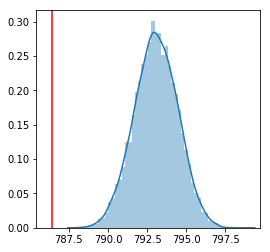

In [12]:
fig, ax = plt.subplots()
sns.distplot(flattened_statistics_permuted.sum(axis=0), ax=ax)
plt.axvline(x=flattened_statistics_original.sum(), color='red')
ax.set_xlim(flattened_statistics_original.sum()-1, flattened_statistics_permuted.sum(axis=0).max()+1)
save_plot(fig, 'ordermatters_hist')

In [27]:
NUM_PERMUTATIONS = 10000
df_filter_blanks = df_mapping[['Blank' not in _ for _ in df_mapping['UserName']]]

df_filter_blanks = df_filter_blanks.reindex(df_distance.index)

groups_filter = set()
for group, df in df_filter_blanks.groupby('UserName'):
    # Remove samples not in akronymer
    df = df[[_ in df_distance.index for _ in df.index]]
    # Verify after filter there are more than 1 sample        
    if df.shape[0] <= 1:
        groups_filter.add(group)

df_filter_blanks = df_filter_blanks[[_ not in groups_filter for _ in df_filter_blanks['UserName']]]

statistic_original = 0.
for group, df in df_filter_blanks.groupby('UserName'):
    statistic_original += df_distance.loc[df.index, df.index].sum().sum()/2

statistics_permuted = np.zeros(NUM_PERMUTATIONS)
for i in range(NUM_PERMUTATIONS):
    df_filter_blanks['UserName'] = np.random.permutation(df_filter_blanks['UserName'])
    for group, df in df_filter_blanks.groupby('UserName'):
        statistics_permuted[i] += df_distance.loc[df.index, df.index].sum().sum()/2

In [30]:
# Check for significance of order
print((np.sum(statistic_original >= statistics_permuted)+1)/(NUM_PERMUTATIONS+1.))

9.99900009999e-05


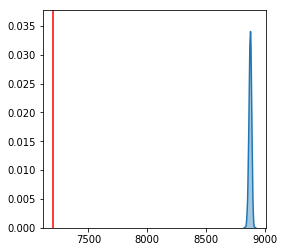

In [29]:
# Retrieve a vector sample numbers, in order of date
fig, ax = plt.subplots()
sns.distplot(statistics_permuted, ax=ax)
plt.axvline(x=statistic_original, color='red')
#ax.set_xlim(statistic_original-1, statistics_permuted.max()+1)
save_plot(fig, 'personmatters_hist')